# Single and Combined Features Evaluations

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

In [3]:
# Setup font size for figures
plt.rcParams.update({'font.size': 22})

# Define Features Lists

In [4]:
# Define the different set of features to use in classifiers

# Structural pair-wise features + min. sequence identity
pairStruct_features = ['fident_struct', 'bits_struct', 'alntmscore_struct', 'qtmscore_struct','ttmscore_struct',
                'alnlen_struct', 'evalue_struct', 'prob_struct', 'lddt_struct',
                'min_sequence_identity',
                    ]

# Sequence context features (similarity searches) + min. sequence identity
contSeq_features = [
                'rank_seq', 'selfSP_seq', 'taxid_seq',
                'min_sequence_identity'
                    ]

# Structural context features (similarity searches) + min. sequence identity
contStruct_features = ['rank_struct', 'selfSP_struct', 'taxid_struct', 
                'min_sequence_identity'
                    ]

# Structural and Sequence context features (similarity searches) + min. sequence identity
contSeqStruct_features = ['rank_struct', 'selfSP_struct', 'taxid_struct', 
                'rank_seq', 'selfSP_seq', 'taxid_seq',
                'min_sequence_identity'
                    ]

# Protein Language Model embedding distance features + min. sequence identity
plm_features = ['min_sequence_identity',
                'esm2_beginning_of_sequence_cosine','esm2_beginning_of_sequence_euclidean','esm2_beginning_of_sequence_manhattan',
                'esm2_beginning_of_sequence_ts_ss','esm2_end_of_sequence_cosine','esm2_end_of_sequence_euclidean',
                'esm2_end_of_sequence_manhattan','esm2_end_of_sequence_ts_ss','esm2_mean_of_residue_tokens_cosine',
                'esm2_mean_of_residue_tokens_euclidean','esm2_mean_of_residue_tokens_manhattan',
                'esm2_mean_of_residue_tokens_ts_ss',
                'esm2_mean_of_special_tokens_cosine','esm2_mean_of_special_tokens_euclidean',
                'esm2_mean_of_special_tokens_manhattan',
                'esm2_mean_of_special_tokens_ts_ss',
                'ProtT5_per-protein_cosine', 'ProtT5_per-protein_euclidean', 
                'ProtT5_per-protein_manhattan', 'ProtT5_per-protein_ts_ss',
                    ]

# Protein Language Model embedding distance features + min. sequence identity
pairwise_features = ['min_sequence_identity',
                'esm2_beginning_of_sequence_cosine','esm2_beginning_of_sequence_euclidean','esm2_beginning_of_sequence_manhattan',
                'esm2_beginning_of_sequence_ts_ss','esm2_end_of_sequence_cosine','esm2_end_of_sequence_euclidean',
                'esm2_end_of_sequence_manhattan','esm2_end_of_sequence_ts_ss','esm2_mean_of_residue_tokens_cosine',
                'esm2_mean_of_residue_tokens_euclidean','esm2_mean_of_residue_tokens_manhattan','esm2_mean_of_residue_tokens_ts_ss',
                'esm2_mean_of_special_tokens_cosine','esm2_mean_of_special_tokens_euclidean','esm2_mean_of_special_tokens_manhattan',
                'esm2_mean_of_special_tokens_ts_ss',
                'ProtT5_per-protein_cosine', 'ProtT5_per-protein_euclidean', 'ProtT5_per-protein_manhattan', 'ProtT5_per-protein_ts_ss',
                'fident_struct', 'bits_struct', 'alntmscore_struct', 'qtmscore_struct','ttmscore_struct',
                'alnlen_struct', 'evalue_struct', 'prob_struct', 'lddt_struct',    
                    ]

# All news sequences and structures features to model sequence divergence + min. sequence identity
news_features = ['min_sequence_identity',
                'rank_struct', 'selfSP_struct', 'taxid_struct', 
                'fident_struct', 'bits_struct', 'alntmscore_struct', 'qtmscore_struct','ttmscore_struct',
                'alnlen_struct', 'evalue_struct', 'prob_struct', 'lddt_struct',
                'rank_seq', 'selfSP_seq', 'taxid_seq', 
                'esm2_beginning_of_sequence_cosine','esm2_beginning_of_sequence_euclidean','esm2_beginning_of_sequence_manhattan',
                'esm2_beginning_of_sequence_ts_ss','esm2_end_of_sequence_cosine','esm2_end_of_sequence_euclidean',
                'esm2_end_of_sequence_manhattan','esm2_end_of_sequence_ts_ss','esm2_mean_of_residue_tokens_cosine',
                'esm2_mean_of_residue_tokens_euclidean','esm2_mean_of_residue_tokens_manhattan','esm2_mean_of_residue_tokens_ts_ss',
                'esm2_mean_of_special_tokens_cosine','esm2_mean_of_special_tokens_euclidean','esm2_mean_of_special_tokens_manhattan',
                'esm2_mean_of_special_tokens_ts_ss',
                'ProtT5_per-protein_cosine', 'ProtT5_per-protein_euclidean', 'ProtT5_per-protein_manhattan', 'ProtT5_per-protein_ts_ss',
                    ]



# Pairwise Features & Classifiers

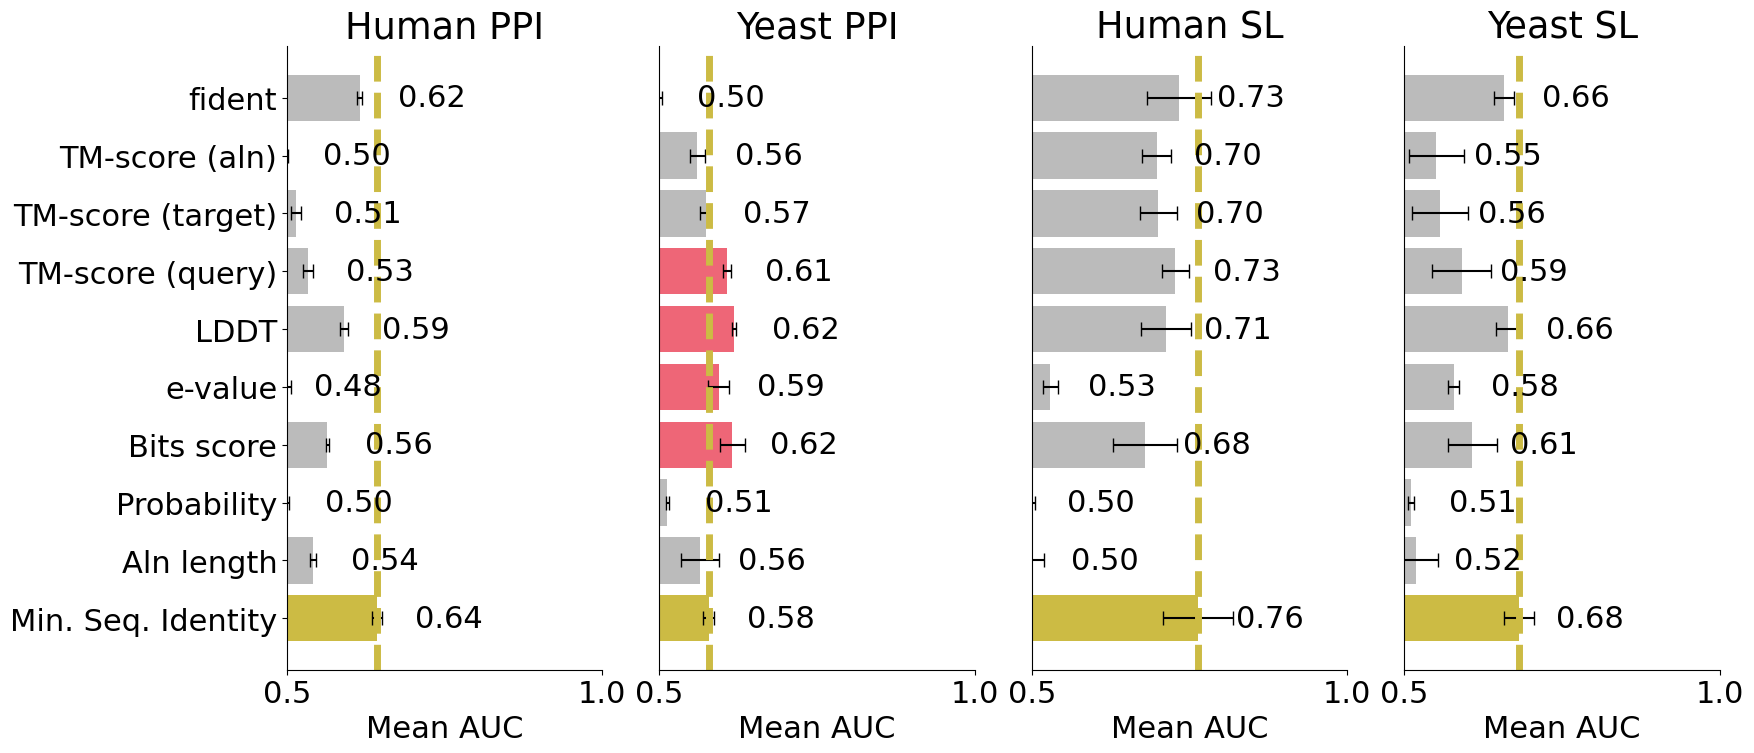

In [5]:
# Define datasets
datasets = {
    'Human PPI': './data/ens111_human_BioPlex.csv',
    'Yeast PPI': './data/ens111_yeast_Interactome.csv',
    'Human SL': './data/ens111_human_SL.csv',
    'Yeast SL': './data/ens111_yeast_SL.csv',
}

# Define features sets
feature_sets = {
    'Min. Seq. Identity': ['min_sequence_identity'],
    'Aln length': ['alnlen_struct'],
    'Probability': ['prob_struct'],
    'Bits score': ['bits_struct'],
    'e-value': ['evalue_struct'],
    'LDDT': ['lddt_struct'],
    'TM-score (query)': ['qtmscore_struct'],
    'TM-score (target)': ['ttmscore_struct'],
    'TM-score (aln)': ['alntmscore_struct'],
    'fident': ['fident_struct'],
}

# Define a new function for cross-validation to store curves
def run_cross_validation_with_curves(classifier, X, y, nfolds=4):
    aucs = []
    aps = []
    kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=3)
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        classifier.fit(X_train, y_train)
        y_proba = classifier.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        aucs.append(auc)
        aps.append(average_precision_score(y_test, y_proba))
    
    return np.mean(aucs), np.std(aucs), np.mean(aps), np.std(aps)

# Define classifier
classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Function to load dataset (placeholder)
def load_dataset(path):
    # Implement your dataset loading logic here
    return pd.read_csv(path)


# Prepare to store results
results = []

# Evaluate each dataset with each feature set
for name, path in datasets.items():
    df = load_dataset(path)
    if 'same_func_ppi' in df: 
        df['SL'] = df['same_func_ppi']
    X = df.drop('SL', axis=1)
    y = df['SL']
    
    for feature_set_name, features in feature_sets.items():
        mean_auc, std_auc, mean_ap, std_ap = run_cross_validation_with_curves(classifier, X[features], y)
        results.append((name, feature_set_name, mean_auc, std_auc, mean_ap, std_ap))

# Create DataFrame from results
results_df = pd.DataFrame(results, columns=['Dataset', 'Feature Set', 'Mean AUC', 'Std AUC', 'Mean Precision', 'Std Precision'])

# Plotting

# Unique datasets and feature sets
datasets = results_df['Dataset'].unique()

# Create a figure with 1 row of subplots (horizontal bar plots)
fig, axes = plt.subplots(1, len(datasets), figsize=(18, 8))

# Iterate through each dataset and plot a horizontal bar chart in the first row
for i, dataset in enumerate(datasets):

    ax = axes[i]
    subset = results_df[results_df['Dataset'] == dataset]
    y_pos = np.arange(len(subset['Feature Set']))  # the label locations

    # Define colors for bars based on comparison to 'Minimum Sequence Identity'
    min_seq_identity_mean_auc = subset[subset['Feature Set'] == 'Min. Seq. Identity']['Mean AUC'].values[0]

    def get_color(mean_auc, min_auc):
        if mean_auc > min_auc:
            return '#EE6677'
        elif mean_auc < min_auc:
            return '#BBBBBB'
        else:
            return '#CCBB44'

    # Draw horizontal bars with error bars
    bars = ax.barh(y_pos, subset['Mean AUC'], 
                   color=[get_color(mean_auc, min_seq_identity_mean_auc) for mean_auc in subset['Mean AUC']],
                   xerr=subset['Std AUC'], capsize=5)  # Include error bars

    ax.set_yticks(y_pos)
    ax.set_xlim(0.5, 1)  # Set x-axis limits from 0.5 to 1
    ax.set_title(dataset)
    
    if i == 0:
        ax.set_yticklabels(subset['Feature Set'])
    else:
        ax.set_yticks([])
    
    ax.set_xlabel('Mean AUC')
    
    # Add AUC values on the bars
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.03 if width > 0.9 else width + 0.06
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

    # Draw a horizontal line for the 'Minimum Sequence Identity' mean AUC
    ax.axvline(x=min_seq_identity_mean_auc, color='#CCBB44', linestyle='--', linewidth=5)

# Adjust layout
plt.tight_layout()

# Don't show all subplot edges
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.set_xticks([0.5, 1.0])

# Show the plot
plt.show()


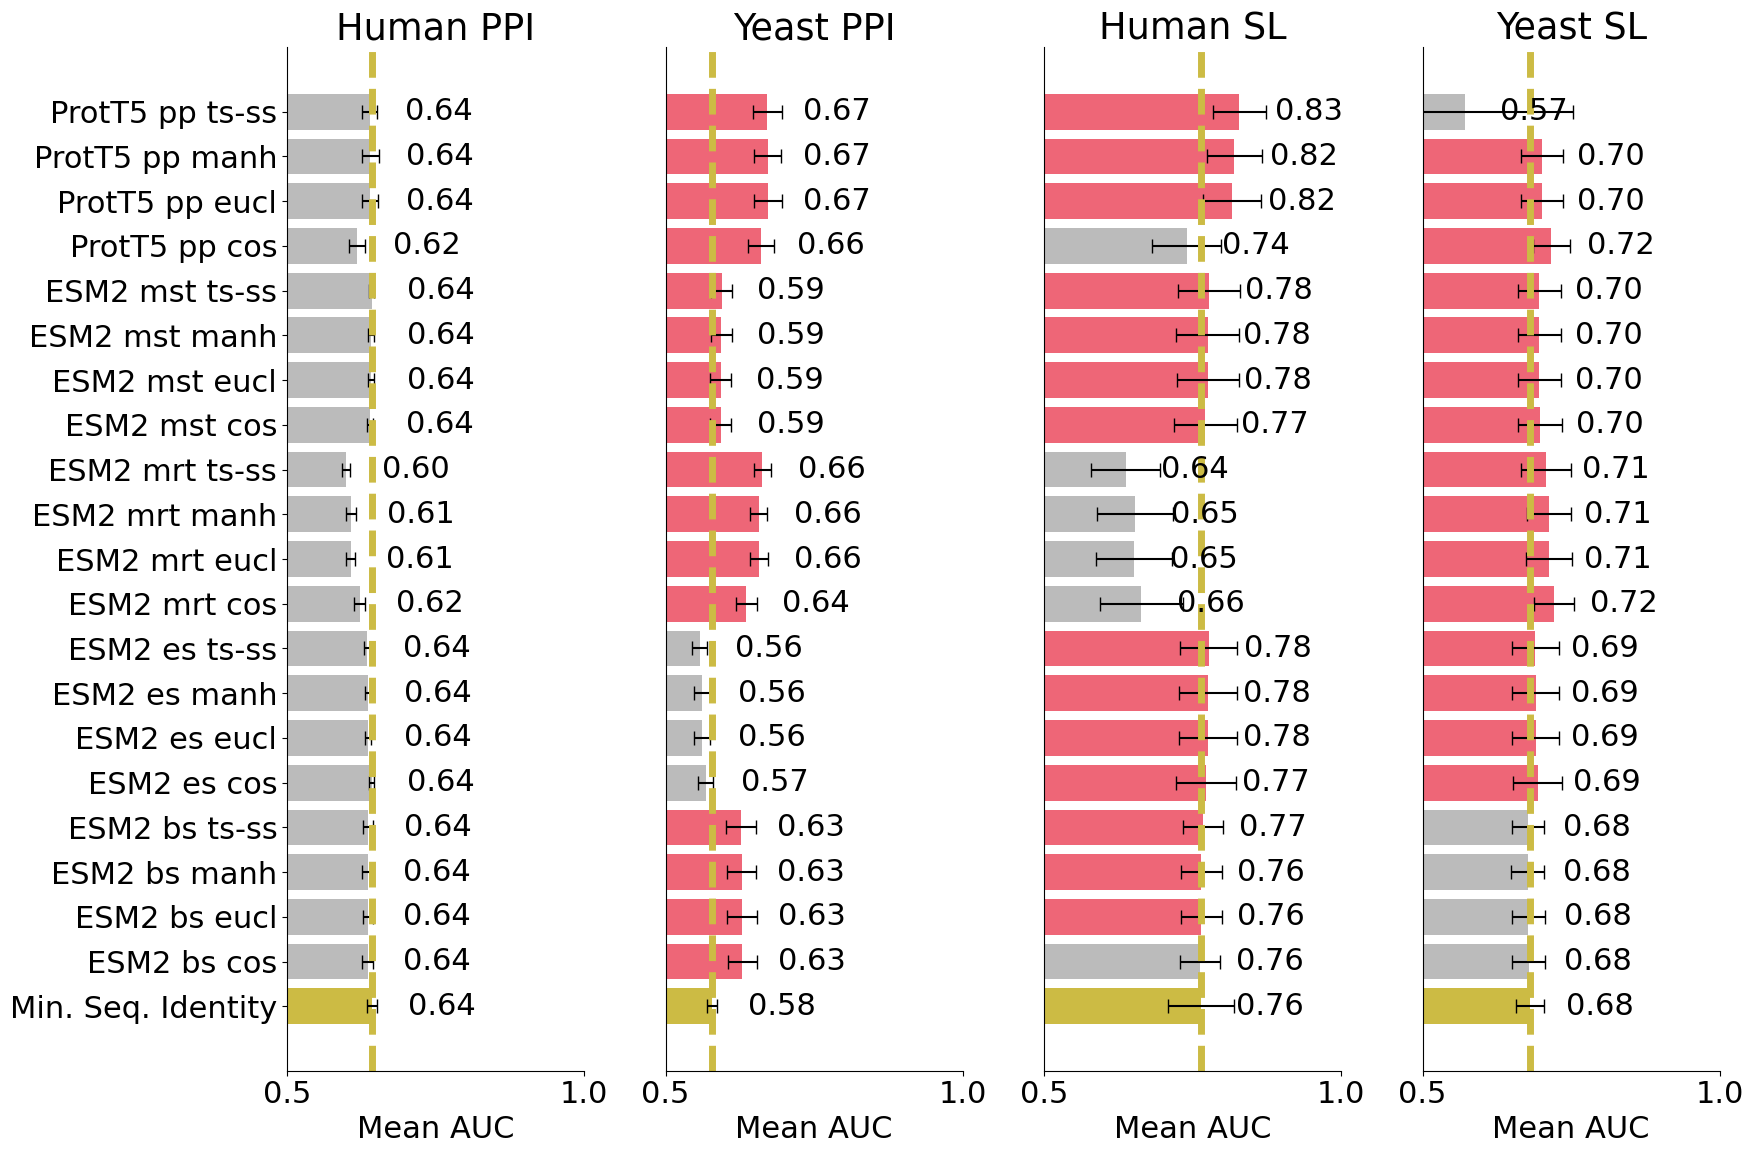

In [6]:
# Define datasets
datasets = {
    'Human PPI': './data/ens111_human_BioPlex.csv',
    'Yeast PPI': './data/ens111_yeast_Interactome.csv',
    'Human SL': './data/ens111_human_SL.csv',
    'Yeast SL': './data/ens111_yeast_SL.csv',
}

# Define features sets
feature_sets = {
    'Min. Seq. Identity': ['min_sequence_identity'],
    'ESM2 bs cos': ['esm2_beginning_of_sequence_cosine'],
    'ESM2 bs eucl': ['esm2_beginning_of_sequence_euclidean'],
    'ESM2 bs manh': ['esm2_beginning_of_sequence_manhattan'],
    'ESM2 bs ts-ss': ['esm2_beginning_of_sequence_ts_ss'],
    'ESM2 es cos': ['esm2_end_of_sequence_cosine'],
    'ESM2 es eucl': ['esm2_end_of_sequence_euclidean'],
    'ESM2 es manh': ['esm2_end_of_sequence_manhattan'],
    'ESM2 es ts-ss': ['esm2_end_of_sequence_ts_ss'],
    'ESM2 mrt cos': ['esm2_mean_of_residue_tokens_cosine'],
    'ESM2 mrt eucl': ['esm2_mean_of_residue_tokens_euclidean'],
    'ESM2 mrt manh': ['esm2_mean_of_residue_tokens_manhattan'],
    'ESM2 mrt ts-ss': ['esm2_mean_of_residue_tokens_ts_ss'],
    'ESM2 mst cos': ['esm2_mean_of_special_tokens_cosine'],
    'ESM2 mst eucl': ['esm2_mean_of_special_tokens_euclidean'],
    'ESM2 mst manh': ['esm2_mean_of_special_tokens_manhattan'],
    'ESM2 mst ts-ss': ['esm2_mean_of_special_tokens_ts_ss'],
    'ProtT5 pp cos': ['ProtT5_per-protein_cosine'], 
    'ProtT5 pp eucl': ['ProtT5_per-protein_euclidean'], 
    'ProtT5 pp manh': ['ProtT5_per-protein_manhattan'],
    'ProtT5 pp ts-ss': ['ProtT5_per-protein_ts_ss'],

}

# Define a new function for cross-validation to store curves
def run_cross_validation_with_curves(classifier, X, y, nfolds=4):
    aucs = []
    aps = []
    kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=3)
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        classifier.fit(X_train, y_train)
        y_proba = classifier.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        aucs.append(auc)
        aps.append(average_precision_score(y_test, y_proba))
    
    return np.mean(aucs), np.std(aucs), np.mean(aps), np.std(aps)

# Define classifier
classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Function to load dataset (placeholder)
def load_dataset(path):
    # Implement your dataset loading logic here
    return pd.read_csv(path)

# Prepare to store results
results = []

# Evaluate each dataset with each feature set
for name, path in datasets.items():
    df = load_dataset(path)
    if 'same_func_ppi' in df: 
        df['SL'] = df['same_func_ppi']
    X = df.drop('SL', axis=1)
    y = df['SL']
    
    for feature_set_name, features in feature_sets.items():
        mean_auc, std_auc, mean_ap, std_ap = run_cross_validation_with_curves(classifier, X[features], y)
        results.append((name, feature_set_name, mean_auc, std_auc, mean_ap, std_ap))

# Create DataFrame from results
results_df = pd.DataFrame(results, columns=['Dataset', 'Feature Set', 'Mean AUC', 'Std AUC', 'Mean Precision', 'Std Precision'])

# Plotting

# Unique datasets and feature sets
datasets = results_df['Dataset'].unique()

# Create a figure with 1 row of subplots (horizontal bar plots)
fig, axes = plt.subplots(1, len(datasets), figsize=(18, 12))

# Iterate through each dataset and plot a horizontal bar chart in the first row
for i, dataset in enumerate(datasets):

    ax = axes[i]
    subset = results_df[results_df['Dataset'] == dataset]
    y_pos = np.arange(len(subset['Feature Set']))  # the label locations

    # Define colors for bars based on comparison to 'Minimum Sequence Identity'
    min_seq_identity_mean_auc = subset[subset['Feature Set'] == 'Min. Seq. Identity']['Mean AUC'].values[0]

    def get_color(mean_auc, min_auc):
        if mean_auc > min_auc:
            return '#EE6677'
        elif mean_auc < min_auc:
            return '#BBBBBB'
        else:
            return '#CCBB44'

    # Draw horizontal bars with error bars
    bars = ax.barh(y_pos, subset['Mean AUC'], 
                   color=[get_color(mean_auc, min_seq_identity_mean_auc) for mean_auc in subset['Mean AUC']],
                   xerr=subset['Std AUC'], capsize=5)  # Include error bars

    ax.set_yticks(y_pos)
    ax.set_xlim(0.5, 1)  # Set x-axis limits from 0.5 to 1
    ax.set_title(dataset)
    
    if i == 0:
        ax.set_yticklabels(subset['Feature Set'])
    else:
        ax.set_yticks([])
    
    ax.set_xlabel('Mean AUC')
    
    # Add AUC values on the bars
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.03 if width > 0.9 else width + 0.06
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

    # Draw a horizontal line for the 'Minimum Sequence Identity' mean AUC
    ax.axvline(x=min_seq_identity_mean_auc, color='#CCBB44', linestyle='--', linewidth=5)


# Don't show all subplot edges
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.set_xticks([0.5, 1.0])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


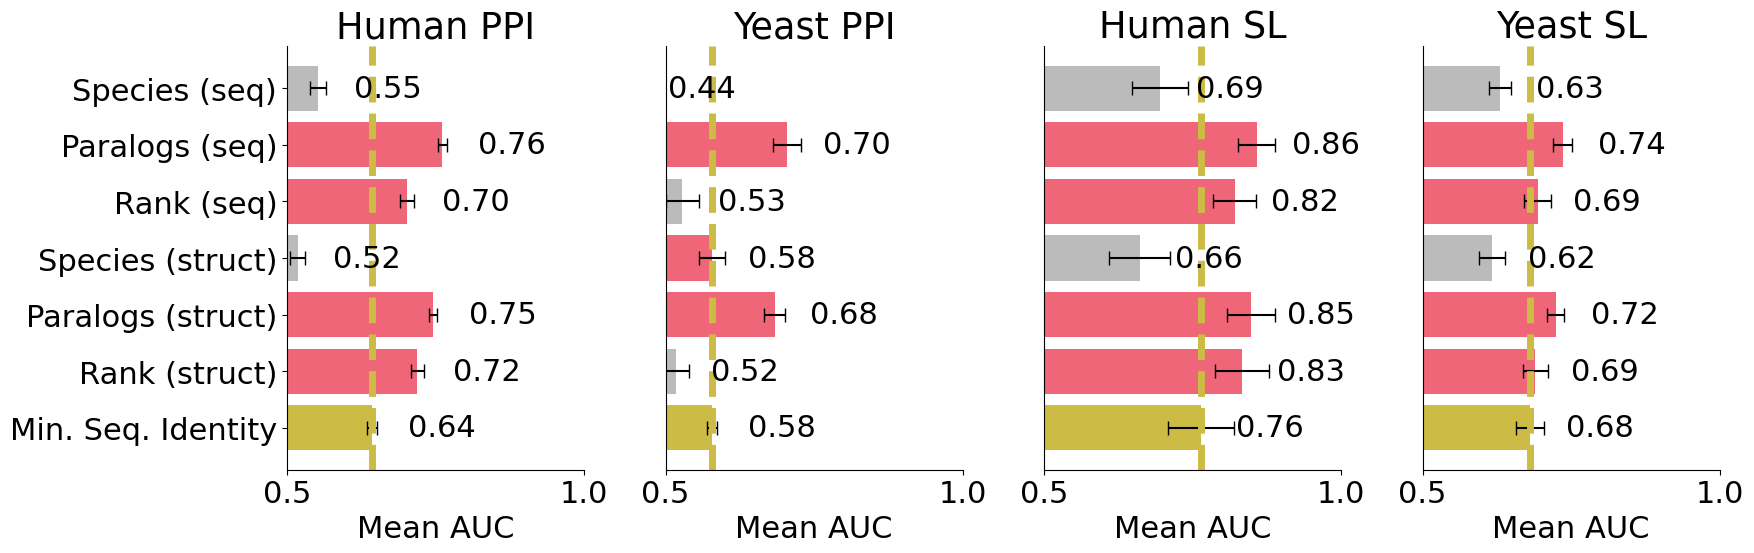

In [14]:
# Define datasets
datasets = {
    'Human PPI': './data/ens111_human_BioPlex.csv',
    'Yeast PPI': './data/ens111_yeast_Interactome.csv',
    'Human SL': './data/ens111_human_SL.csv',
    'Yeast SL': './data/ens111_yeast_SL.csv',
}

# Define features sets
feature_sets = {
    'Min. Seq. Identity': ['min_sequence_identity'],

    'Rank (struct)': ['rank_struct'], 
    'Paralogs (struct)': ['selfSP_struct'], 
    'Species (struct)': ['taxid_struct'], 
                
    'Rank (seq)': ['rank_seq'], 
    'Paralogs (seq)': ['selfSP_seq'], 
    'Species (seq)': ['taxid_seq'],
}

# Define a new function for cross-validation to store curves
def run_cross_validation_with_curves(classifier, X, y, nfolds=4):
    aucs = []
    aps = []
    kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=3) #3
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        classifier.fit(X_train, y_train)
        y_proba = classifier.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        aucs.append(auc)
        aps.append(average_precision_score(y_test, y_proba))
    
    return np.mean(aucs), np.std(aucs), np.mean(aps), np.std(aps)

# Define classifier
classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Function to load dataset (placeholder)
def load_dataset(path):
    # Implement your dataset loading logic here
    return pd.read_csv(path)

# Prepare to store results
results = []

# Evaluate each dataset with each feature set
for name, path in datasets.items():
    df = load_dataset(path)
    if 'same_func_ppi' in df: 
        df['SL'] = df['same_func_ppi']
    X = df.drop('SL', axis=1)
    y = df['SL']
    
    for feature_set_name, features in feature_sets.items():
        mean_auc, std_auc, mean_ap, std_ap = run_cross_validation_with_curves(classifier, X[features], y)
        results.append((name, feature_set_name, mean_auc, std_auc, mean_ap, std_ap))

# Create DataFrame from results
results_df = pd.DataFrame(results, columns=['Dataset', 'Feature Set', 'Mean AUC', 'Std AUC', 'Mean Precision', 'Std Precision'])

# Plotting

# Unique datasets and feature sets
datasets = results_df['Dataset'].unique()

# Create a figure with 1 row of subplots (horizontal bar plots)
fig, axes = plt.subplots(1, len(datasets), figsize=(18, 6))

# Iterate through each dataset and plot a horizontal bar chart in the first row
for i, dataset in enumerate(datasets):

    ax = axes[i]
    subset = results_df[results_df['Dataset'] == dataset]
    y_pos = np.arange(len(subset['Feature Set']))  # the label locations

    # Define colors for bars based on comparison to 'Minimum Sequence Identity'
    min_seq_identity_mean_auc = subset[subset['Feature Set'] == 'Min. Seq. Identity']['Mean AUC'].values[0]

    def get_color(mean_auc, min_auc):
        if mean_auc > min_auc:
            return '#EE6677'
        elif mean_auc < min_auc:
            return '#BBBBBB'
        else:
            return '#CCBB44'

    # Draw horizontal bars with error bars
    bars = ax.barh(y_pos, subset['Mean AUC'], 
                   color=[get_color(mean_auc, min_seq_identity_mean_auc) for mean_auc in subset['Mean AUC']],
                   xerr=subset['Std AUC'], capsize=5)  # Include error bars

    ax.set_yticks(y_pos)
    ax.set_xlim(0.5, 1)  # Set x-axis limits from 0.5 to 1
    ax.set_title(dataset)
    
    if i == 0:
        ax.set_yticklabels(subset['Feature Set'])
    else:
        ax.set_yticks([])
    
    ax.set_xlabel('Mean AUC')
    
    # Add AUC values on the bars
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.03 if width > 0.9 else width + 0.06
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

    # Draw a horizontal line for the 'Minimum Sequence Identity' mean AUC
    ax.axvline(x=min_seq_identity_mean_auc, color='#CCBB44', linestyle='--', linewidth=5)


# Don't show all subplot edges
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.set_xticks([0.5, 1.0])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


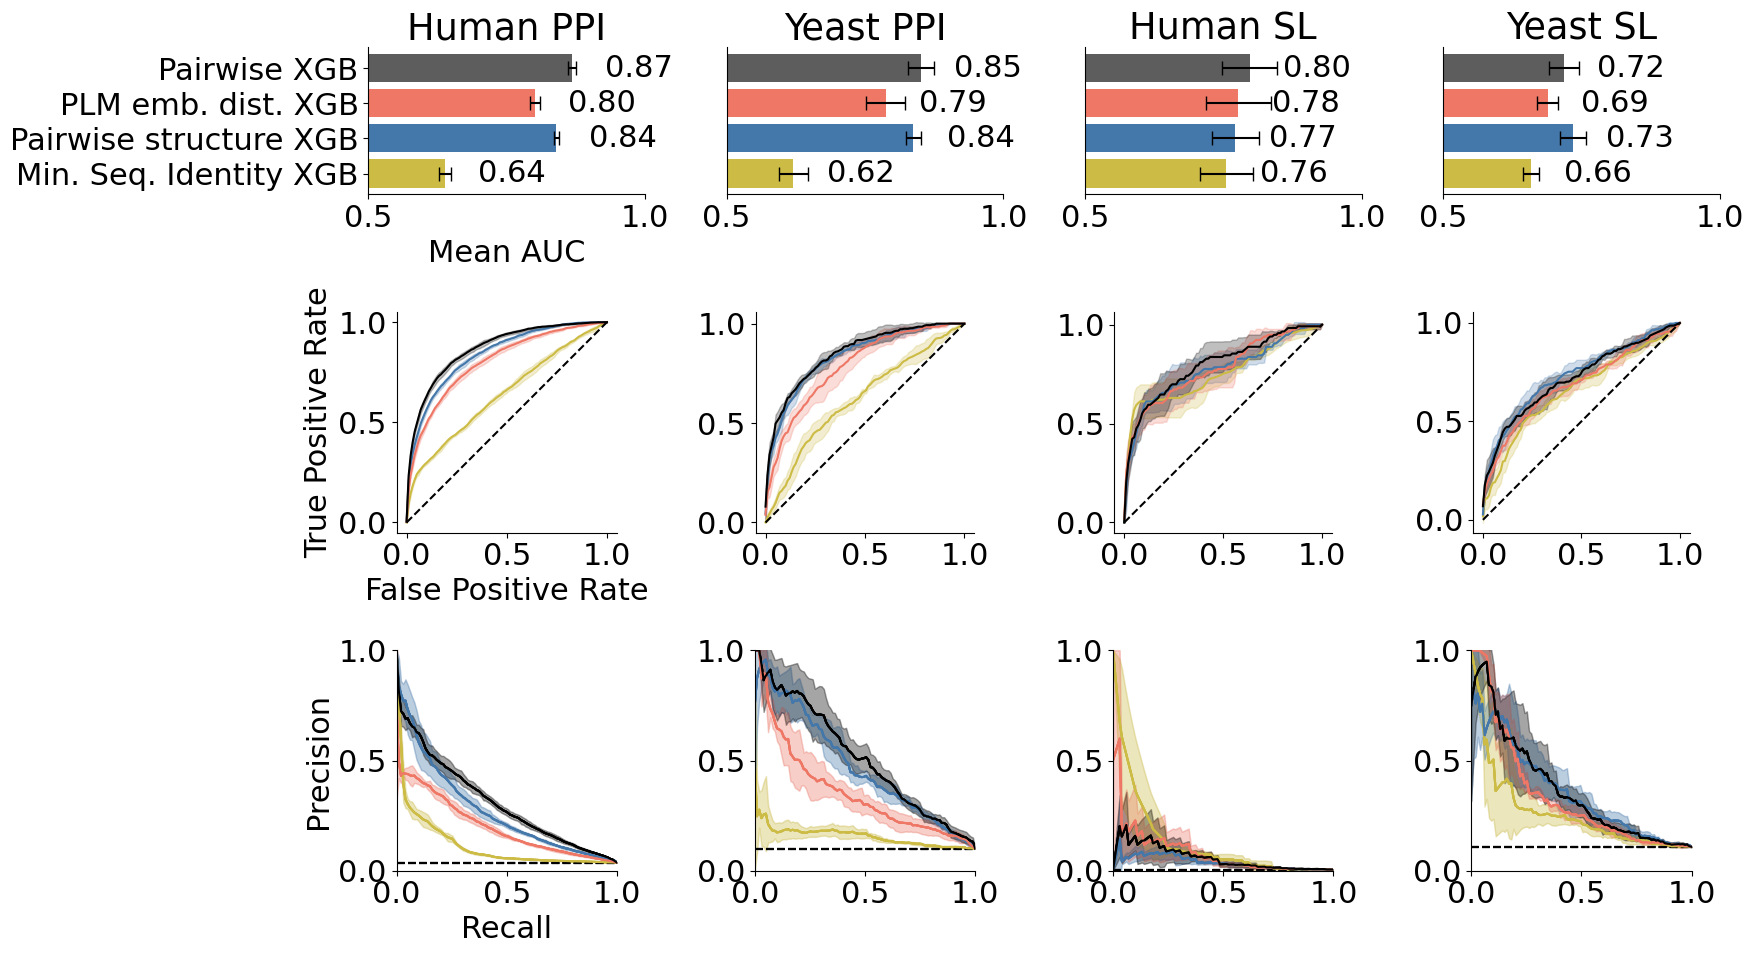

In [12]:
class_mod = 'XGB'

# All classifiers


# Define datasets
datasets = {
    'Human PPI': './data/ens111_human_BioPlex.csv',
    'Yeast PPI': './data/ens111_yeast_Interactome.csv',
    'Human SL': './data/ens111_human_SL.csv',
    'Yeast SL': './data/ens111_yeast_SL.csv',
}

# Define features sets: uncomment / comment depending of features of interests
feature_sets = {
    f'Min. Seq. Identity {class_mod}': ['min_sequence_identity'],
    f'Pairwise structure {class_mod}': pairStruct_features,
    f'PLM emb. dist. {class_mod}': plm_features,
    f'Pairwise {class_mod}': pairwise_features,
    #f'Simil. Search Seq. {class_mod}': contSeq_features, 
    #f'Simil. Search Struct. {class_mod}': contStruct_features,
    #f'Simil. Search Seq. & Struct. {class_mod}': contSeqStruct_features,
}

# Define a new function for cross-validation to store curves
def run_cross_validation_with_curves(classifier, X, y, nfolds=4):
    aucs = []
    aps = []
    roc_curves = []
    pr_curves = []
    kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=3)
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        classifier.fit(X_train, y_train)
        y_proba = classifier.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        aucs.append(auc)
        aps.append(average_precision_score(y_test, y_proba))
        
        # Store ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_curves.append((fpr, tpr))
        
        # Store Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_curves.append((precision, recall))
    
    return np.mean(aucs), np.std(aucs), np.mean(aps), np.std(aps), roc_curves, pr_curves

# Define classifier
if class_mod == 'XGB':
    classifier = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(
            n_estimators=600,
            random_state=8,
            learning_rate=0.1,
            colsample_bytree=0.5,
            use_label_encoder=False,
            eval_metric='logloss'
        ))
    ])
elif class_mod == 'RF':
    classifier = RandomForestClassifier(n_estimators=600, random_state=8, max_features=0.5, max_depth=3, min_samples_leaf=8)
elif class_mod == ' LR':
    classifier = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

# Prepare to store results
results = []
roc_curves_all = {}
pr_curves_all = {}
y_all = {}

# Evaluate each dataset with each feature set
for name, path in datasets.items():
    df = load_dataset(path)
    if 'same_func_ppi' in df: df['SL'] = df['same_func_ppi']
    X = df.drop('SL', axis=1)
    y = df['SL']
    y_all[name] = y
    
    for feature_set_name, features in feature_sets.items():
        mean_auc, std_auc, mean_ap, std_ap, roc_curves, pr_curves = run_cross_validation_with_curves(classifier, X[features], y)
        results.append((name, feature_set_name, mean_auc, std_auc, mean_ap, std_ap))
        
        # Store curves
        if name not in roc_curves_all:
            roc_curves_all[name] = {}
            pr_curves_all[name] = {}
        roc_curves_all[name][feature_set_name] = roc_curves
        pr_curves_all[name][feature_set_name] = pr_curves

# Create DataFrame from results
results_df = pd.DataFrame(results, columns=['Dataset', 'Feature Set', 'Mean AUC', 'Std AUC', 'Mean Precision', 'Std Precision'])

# Plotting

# Unique datasets and feature sets
datasets = results_df['Dataset'].unique()
feature_sets = results_df['Feature Set'].unique()

# Create a figure with 9 subplots (3 rows, len(datasets) columns)
fig, axes = plt.subplots(3, len(datasets), figsize=(18, 10),
                       gridspec_kw = {'height_ratios':[2,3,3]})  # Adjust the figsize to fit your screen or preferences

def draw_chance_lines(ax, y):
    no_skill = sum(y) / len(y)
    ax.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label=f'Chance ({no_skill:.2f})')

# Iterate through each dataset and plot a horizontal bar chart in the first row
for i, dataset in enumerate(datasets):

    # Define feature set colors
    feature_set_colors = {
        f'Min. Seq. Identity {class_mod}': '#CCBB44',
        f'Pairwise structure {class_mod}': '#4477AA',
        f'PLM emb. dist. {class_mod}': '#ee7766',
        f'Pairwise {class_mod}': '#5d5d5d',
        f'Simil. Search Seq. {class_mod}': '#AA3377',
        f'Simil. Search Struct. {class_mod}': '#66CCEE',
        f'Simil. Search Seq. & Struct. {class_mod}': '#228833',
    }

    ax = axes[0, i]
    subset = results_df[results_df['Dataset'] == dataset]
    y_pos = np.arange(len(subset['Feature Set']))  # the label locations

    # Draw horizontal bars with error bars
    bars = ax.barh(y_pos, subset['Mean AUC'], color=[feature_set_colors[feat] for feat in subset['Feature Set']],
                   xerr=subset['Std AUC'], capsize=5)  # Include error bars

    ax.set_yticks(y_pos)
    ax.set_xlim(0.5, 1)  # Set x-axis limits from 0.5 to 1
    ax.set_title(dataset)
    
    if i == 0:
        ax.set_yticklabels(subset['Feature Set'])
        #ax.set_ylabel('Feature Set')
    else:
        ax.set_yticks([])
    
    ax.set_xlabel('Mean AUC')
    
    # Add AUC values on the bars
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.03 if width > 0.9 else width + 0.06
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

    # Change overall classifier color for better curves
    # Define feature set colors
    feature_set_colors = {
        f'Min. Seq. Identity {class_mod}': '#CCBB44',
        f'Pairwise structure {class_mod}': '#4477AA',
        f'PLM emb. dist. {class_mod}': '#ee7766',
        f'Pairwise {class_mod}':'#000000',
        f'Simil. Search Seq. {class_mod}': '#AA3377',
        f'Simil. Search Struct. {class_mod}': '#66CCEE',
        f'Simil. Search Seq. & Struct. {class_mod}': '#228833',
    }
    
    # Plot ROC curves in the second row
    ax_roc = axes[1, i]
    mean_fpr = np.linspace(0, 1, 100)
    for feature_set in feature_sets:
        tprs = []
        for fpr, tpr in roc_curves_all[dataset][feature_set]:
            tprs.append(np.interp(mean_fpr, fpr, tpr))
        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        ax_roc.plot(mean_fpr, mean_tpr, color=feature_set_colors[feature_set], label=feature_set)
        ax_roc.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color=feature_set_colors[feature_set], alpha=0.25)
    ax_roc.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    
    
    def plot_precision_recall(ax, pr_curves, feature_set_name, color):
        mean_recall = np.linspace(0, 1, 100)
        precisions = []
        for precision, recall in pr_curves:
            # Interpolating precision values for mean_recall points
            interpolated_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
            precisions.append(interpolated_precision)
            #ax.plot(recall, precision, color=color, alpha=0.3)
        
        # Compute mean and std of the interpolated precisions
        precisions = np.array(precisions)
        mean_precision = np.mean(precisions, axis=0)
        std_precision = np.std(precisions, axis=0)
        
        # Plot the mean precision-recall curve and fill the area between mean ± std
        ax.plot(mean_recall, mean_precision, color=color, label=feature_set_name)
        ax.fill_between(mean_recall, mean_precision - std_precision, mean_precision + std_precision, color=color, alpha=0.1)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        #ax.legend(loc='best')


   # Plot Precision-Recall curves in the third row
    for i, dataset in enumerate(datasets):
        ax_pr = axes[2, i]
        # Use the adequate label distribution for the current dataset
        y = y_all[dataset]
        draw_chance_lines(ax_pr, y)
        for feature_set in feature_sets:
            plot_precision_recall(ax_pr, pr_curves_all[dataset][feature_set], feature_set, feature_set_colors[feature_set])


# Don't show all subplot edges
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.set_xticks([0.5, 1.0])

# Looping only over the first subplot of each row
for ax in axes[:, 1:].flatten():
    ax.set_xlabel('')
    #ax.set_xticks([])
    ax.set_ylabel('')
    #ax.set_yticks([])

# Ensure the ROC and PR curves are square
for ax in axes[1:, :].flatten():
    ax.set_aspect('equal', 'box')

# Remove titles from second and third rows
for ax in axes[1:, :].flatten():
    ax.set_title('')
    ax.set_xticks([0.0, 0.5, 1.0])
    ax.set_yticks([0.0, 0.5, 1.0])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## XGBoost - Human - All Classifiers

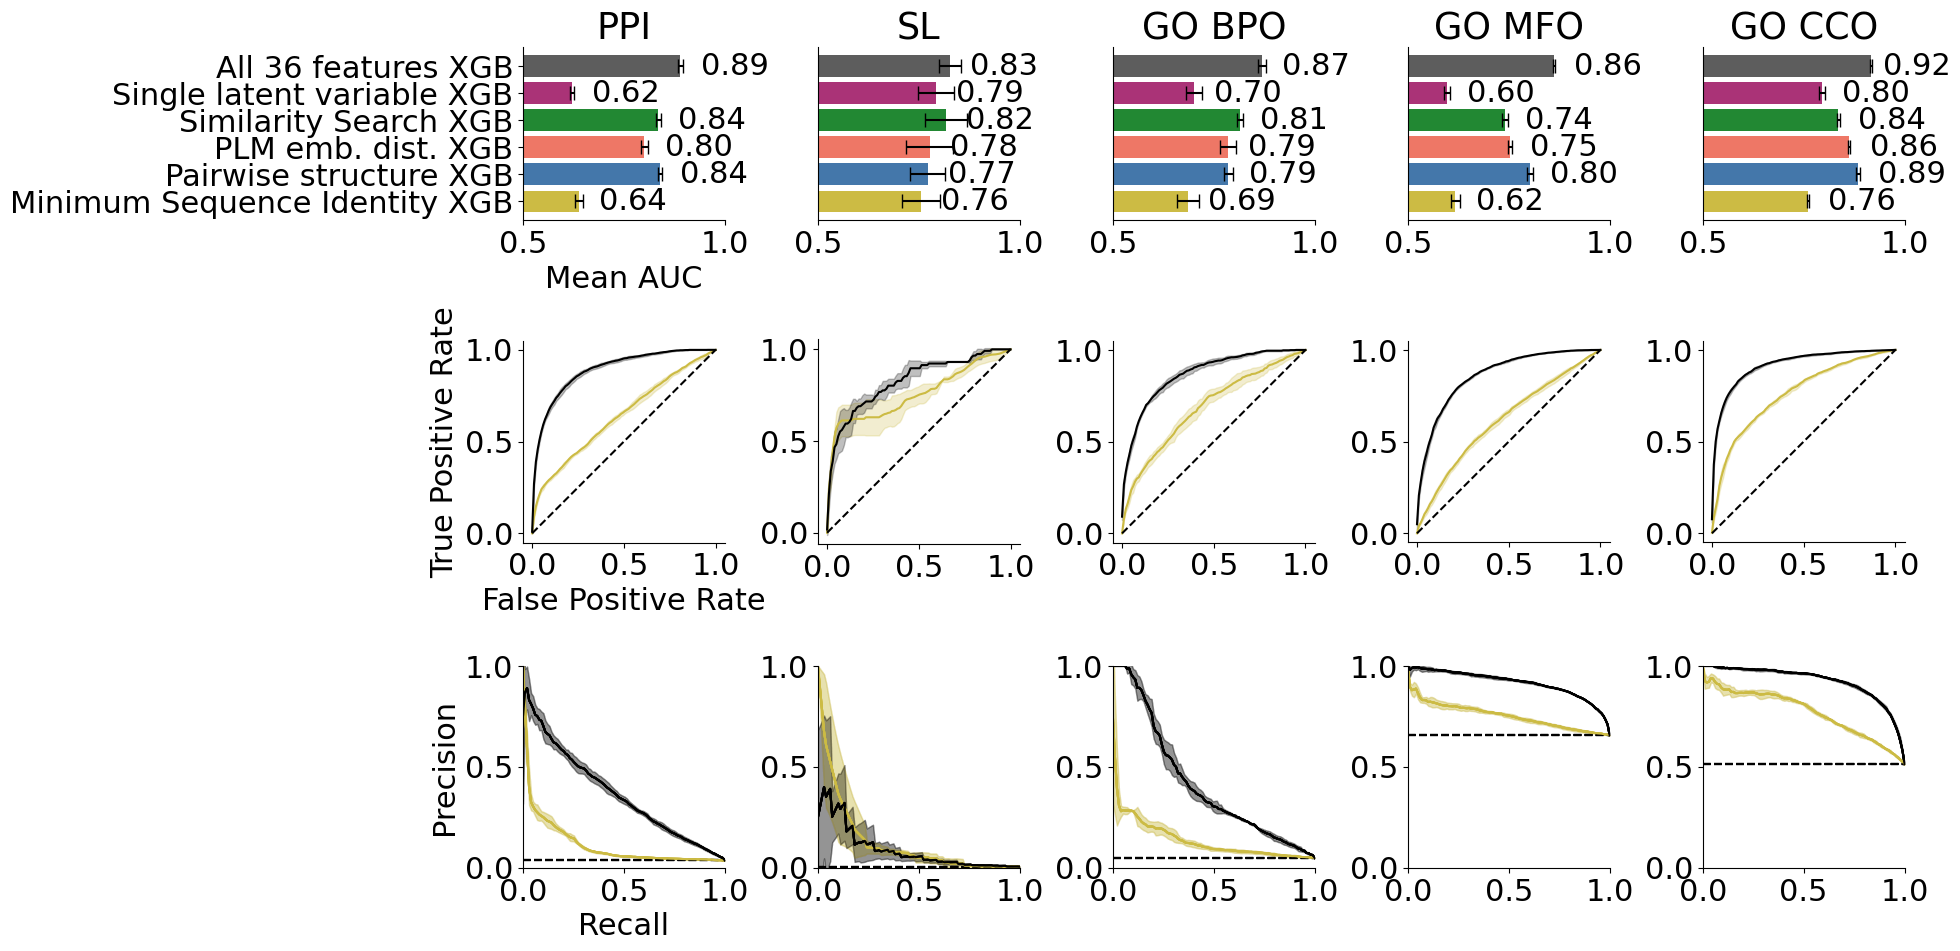

In [15]:
class_mod = 'XGB'

# Define datasets
datasets = {
    'PPI': './data/ens111_human_BioPlex.csv',
    'SL': './data/ens111_human_SL.csv',
    'GO BPO': './data/ens111_human_BPO.csv',
    'GO MFO': './data/ens111_human_MFO.csv',
    'GO CCO': './data/ens111_human_CCO.csv',
}

# Define features sets
feature_sets = {
    f'Minimum Sequence Identity {class_mod}': ['min_sequence_identity'],
    f'Pairwise structure {class_mod}': pairStruct_features,
    f'PLM emb. dist. {class_mod}': plm_features,
    f'Similarity Search {class_mod}': contSeqStruct_features,
    f'Single latent variable {class_mod}': ['dim1_PCA'],
    f'All {len(news_features)} features {class_mod}': news_features,
}

# Define classifier
if class_mod == 'XGB':
    classifier = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(
            n_estimators=600,
            random_state=8,
            learning_rate=0.1,
            colsample_bytree=0.5,
            use_label_encoder=False,
            eval_metric='logloss'
        ))
    ])
elif class_mod == 'RF':
    classifier = RandomForestClassifier(n_estimators=600, random_state=8, max_features=0.5, max_depth=3, min_samples_leaf=8)
elif class_mod == 'LR':
    classifier = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

# Define a new function for cross-validation to store curves
def run_cross_validation_with_curves(classifier, X, y, nfolds=4):
    aucs = []
    aps = []
    roc_curves = []
    pr_curves = []
    kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=3)
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        classifier.fit(X_train, y_train)
        y_proba = classifier.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        aucs.append(auc)
        aps.append(average_precision_score(y_test, y_proba))
        
        # Store ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_curves.append((fpr, tpr))
        
        # Store Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_curves.append((precision, recall))
    
    return np.mean(aucs), np.std(aucs), np.mean(aps), np.std(aps), roc_curves, pr_curves


# Prepare to store results
results = []
roc_curves_all = {}
pr_curves_all = {}
y_all = {}

# Evaluate each dataset with each feature set
for name, path in datasets.items():
    df = load_dataset(path)
    if 'same_func_ppi' in df: df['SL'] = df['same_func_ppi']
    X = df.drop('SL', axis=1)
    y = df['SL']
    y_all[name] = y
    
    for feature_set_name, features in feature_sets.items():
        mean_auc, std_auc, mean_ap, std_ap, roc_curves, pr_curves = run_cross_validation_with_curves(classifier, X[features], y)
        results.append((name, feature_set_name, mean_auc, std_auc, mean_ap, std_ap))
        
        # Store curves
        if name not in roc_curves_all:
            roc_curves_all[name] = {}
            pr_curves_all[name] = {}
        roc_curves_all[name][feature_set_name] = roc_curves
        pr_curves_all[name][feature_set_name] = pr_curves

# Create DataFrame from results
results_df = pd.DataFrame(results, columns=['Dataset', 'Feature Set', 'Mean AUC', 'Std AUC', 'Mean Precision', 'Std Precision'])

# Plotting

# Unique datasets and feature sets
datasets = results_df['Dataset'].unique()
feature_sets = results_df['Feature Set'].unique()

# Create a figure with 9 subplots (3 rows, len(datasets) columns)
fig, axes = plt.subplots(3, len(datasets), figsize=(20, 10),
                       gridspec_kw = {'height_ratios':[2.5,3,3]})  # Adjust the figsize to fit your screen or preferences

def draw_chance_lines(ax, y):
    no_skill = sum(y) / len(y)
    ax.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label=f'Chance ({no_skill:.2f})')

# Iterate through each dataset and plot a horizontal bar chart in the first row
for i, dataset in enumerate(datasets):

    # Define feature set colors
    feature_set_colors = {
        f'Minimum Sequence Identity {class_mod}': '#CCBB44',
        f'Pairwise structure {class_mod}': '#4477AA',
        f'PLM emb. dist. {class_mod}': '#ee7766',
        f'Similarity Search {class_mod}': '#228833',
        f'Single latent variable {class_mod}': '#AA3377',
        f'All {len(news_features)} features {class_mod}': '#5d5d5d',
    }

    ax = axes[0, i]
    subset = results_df[results_df['Dataset'] == dataset]
    y_pos = np.arange(len(subset['Feature Set']))  # the label locations

    # Draw horizontal bars with error bars
    bars = ax.barh(y_pos, subset['Mean AUC'], color=[feature_set_colors[feat] for feat in subset['Feature Set']],
                   xerr=subset['Std AUC'], capsize=5)  # Include error bars

    ax.set_yticks(y_pos)
    ax.set_xlim(0.5, 1)  # Set x-axis limits from 0.5 to 1
    ax.set_title(dataset)
    
    if i == 0:
        ax.set_yticklabels(subset['Feature Set'])
        #ax.set_ylabel('Feature Set')
    else:
        ax.set_yticks([])
    
    ax.set_xlabel('Mean AUC')
    
    # Add AUC values on the bars
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.03 if width > 0.9 else width + 0.05
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

    # Change overall classifier color for better curves
    # Define feature set colors
    feature_set_colors = {
        f'Minimum Sequence Identity {class_mod}': '#CCBB44',
        f'Pairwise structure {class_mod}': '#4477AA',
        f'PLM emb. dist. {class_mod}': '#ee7766',
        f'Similarity Search {class_mod}': '#228833',
        f'Single latent variable {class_mod}': '#AA3377',
        f'All {len(news_features)} features {class_mod}': '#000000',
    }
    
    # Plot ROC curves in the second row
    ax_roc = axes[1, i]
    mean_fpr = np.linspace(0, 1, 100)
    for feature_set in feature_sets:
         # Only plot all and sequence identity curves (for simplicity)
        if feature_set in [f'Minimum Sequence Identity {class_mod}', f'All {len(news_features)} features {class_mod}']:
            tprs = []
            for fpr, tpr in roc_curves_all[dataset][feature_set]:
                tprs.append(np.interp(mean_fpr, fpr, tpr))
            mean_tpr = np.mean(tprs, axis=0)
            std_tpr = np.std(tprs, axis=0)
            ax_roc.plot(mean_fpr, mean_tpr, color=feature_set_colors[feature_set], label=feature_set)
            ax_roc.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color=feature_set_colors[feature_set], alpha=0.25)
    ax_roc.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    
    
    def plot_precision_recall(ax, pr_curves, feature_set_name, color):
        mean_recall = np.linspace(0, 1, 100)
        precisions = []
        for precision, recall in pr_curves:
            # Interpolating precision values for mean_recall points
            interpolated_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
            precisions.append(interpolated_precision)
            #ax.plot(recall, precision, color=color, alpha=0.3)
        
        # Compute mean and std of the interpolated precisions
        precisions = np.array(precisions)
        mean_precision = np.mean(precisions, axis=0)
        std_precision = np.std(precisions, axis=0)
        
        # Plot the mean precision-recall curve and fill the area between mean ± std
        ax.plot(mean_recall, mean_precision, color=color, label=feature_set_name)
        ax.fill_between(mean_recall, mean_precision - std_precision, mean_precision + std_precision, color=color, alpha=0.1)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        #ax.legend(loc='best')


   # Plot Precision-Recall curves in the third row
    for i, dataset in enumerate(datasets):
        ax_pr = axes[2, i]
        # Use the adequate label distribution for the current dataset
        y = y_all[dataset]
        draw_chance_lines(ax_pr, y)
        for feature_set in feature_sets:
             # Only plot all and sequence identity curves (for simplicity)
            if feature_set in [f'Minimum Sequence Identity {class_mod}', f'All {len(news_features)} features {class_mod}']:
                plot_precision_recall(ax_pr, pr_curves_all[dataset][feature_set], feature_set, feature_set_colors[feature_set])


# Don't show all subplot edges
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.set_xticks([0.5, 1.0])

# Looping only over the first subplot of each row
for ax in axes[:, 1:].flatten():
    ax.set_xlabel('')
    #ax.set_xticks([])
    ax.set_ylabel('')
    #ax.set_yticks([])

# Ensure the ROC and PR curves are square
for ax in axes[1:, :].flatten():
    ax.set_aspect('equal', 'box')

# Remove titles from second and third rows
for ax in axes[1:, :].flatten():
    ax.set_title('')
    ax.set_xticks([0.0, 0.5, 1.0])
    ax.set_yticks([0.0, 0.5, 1.0])

# Adjust layout
plt.tight_layout()
    
# Show the plot
plt.show()


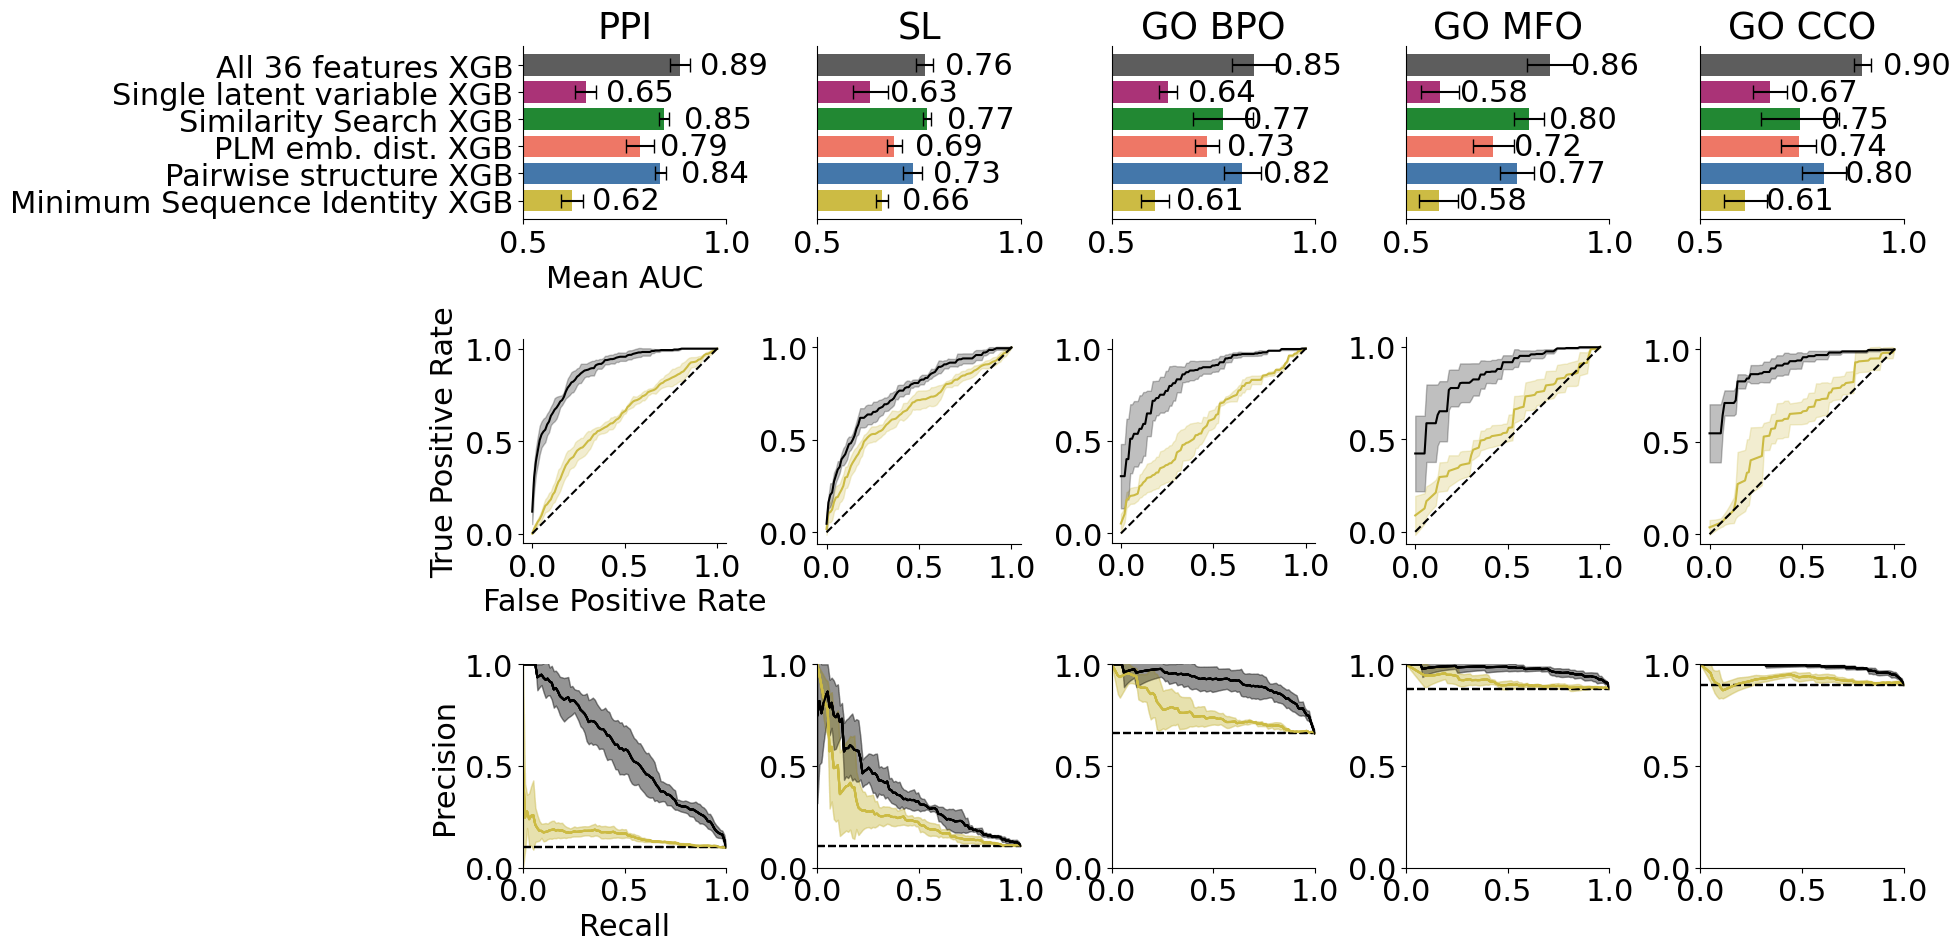

In [16]:
# Yeast

# Define datasets
datasets = {
    'PPI': './data/ens111_yeast_Interactome.csv',
    'SL': './data/ens111_yeast_SL.csv',
    'GO BPO': './data/ens111_yeast_BPO.csv',
    'GO MFO': './data/ens111_yeast_MFO.csv',
    'GO CCO': './data/ens111_yeast_CCO.csv',
}

# Define features sets
feature_sets = {
    f'Minimum Sequence Identity {class_mod}': ['min_sequence_identity'],
    f'Pairwise structure {class_mod}': pairStruct_features,
    f'PLM emb. dist. {class_mod}': plm_features,
    f'Similarity Search {class_mod}': contSeqStruct_features,
    f'Single latent variable {class_mod}': ['dim1_PCA'],
    f'All {len(news_features)} features {class_mod}': news_features,
}

# Prepare to store results
results = []
roc_curves_all = {}
pr_curves_all = {}
y_all = {}

# Evaluate each dataset with each feature set
for name, path in datasets.items():
    df = load_dataset(path)
    if 'same_func_ppi' in df: df['SL'] = df['same_func_ppi']
    X = df.drop('SL', axis=1)
    y = df['SL']
    y_all[name] = y
    
    for feature_set_name, features in feature_sets.items():
        #print(name, feature_set_name) # for debug purpose
        mean_auc, std_auc, mean_ap, std_ap, roc_curves, pr_curves = run_cross_validation_with_curves(classifier, X[features], y)
        results.append((name, feature_set_name, mean_auc, std_auc, mean_ap, std_ap))
        
        # Store curves
        if name not in roc_curves_all:
            roc_curves_all[name] = {}
            pr_curves_all[name] = {}
        roc_curves_all[name][feature_set_name] = roc_curves
        pr_curves_all[name][feature_set_name] = pr_curves

# Create DataFrame from results
results_df = pd.DataFrame(results, columns=['Dataset', 'Feature Set', 'Mean AUC', 'Std AUC', 'Mean Precision', 'Std Precision'])

# Plotting

# Unique datasets and feature sets
datasets = results_df['Dataset'].unique()
feature_sets = results_df['Feature Set'].unique()

# Create a figure with 9 subplots (3 rows, len(datasets) columns)
fig, axes = plt.subplots(3, len(datasets), figsize=(20, 10),
                       gridspec_kw = {'height_ratios':[2.5,3,3]})  # Adjust the figsize to fit your screen or preferences

# Iterate through each dataset and plot a horizontal bar chart in the first row
for i, dataset in enumerate(datasets):

    # Define feature set colors
    feature_set_colors = {
        f'Minimum Sequence Identity {class_mod}': '#CCBB44',
        f'Pairwise structure {class_mod}': '#4477AA',
        f'PLM emb. dist. {class_mod}': '#ee7766',
        f'Similarity Search {class_mod}': '#228833',
        f'Single latent variable {class_mod}': '#AA3377',
        f'All {len(news_features)} features {class_mod}': '#5d5d5d',
    }

    ax = axes[0, i]
    subset = results_df[results_df['Dataset'] == dataset]
    y_pos = np.arange(len(subset['Feature Set']))  # the label locations

    # Draw horizontal bars with error bars
    bars = ax.barh(y_pos, subset['Mean AUC'], color=[feature_set_colors[feat] for feat in subset['Feature Set']],
                   xerr=subset['Std AUC'], capsize=5)  # Include error bars

    ax.set_yticks(y_pos)
    ax.set_xlim(0.5, 1)  # Set x-axis limits from 0.5 to 1
    ax.set_title(dataset)
    
    if i == 0:
        ax.set_yticklabels(subset['Feature Set'])
        #ax.set_ylabel('Feature Set')
    else:
        ax.set_yticks([])
    
    ax.set_xlabel('Mean AUC')
    
    # Add AUC values on the bars
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.03 if width > 0.9 else width + 0.05
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

    # Change overall classifier color for better curves
    # Define feature set colors
    feature_set_colors = {
        f'Minimum Sequence Identity {class_mod}': '#CCBB44',
        f'Pairwise structure {class_mod}': '#4477AA',
        f'PLM emb. dist. {class_mod}': '#ee7766',
        f'Similarity Search {class_mod}': '#228833',
        f'Single latent variable {class_mod}': '#AA3377',
        f'All {len(news_features)} features {class_mod}': '#000000',
    }
    
    # Plot ROC curves in the second row
    ax_roc = axes[1, i]
    mean_fpr = np.linspace(0, 1, 100)
    for feature_set in feature_sets:
        # Only plot all and sequence identity curves (for simplicity)
        if feature_set in [f'Minimum Sequence Identity {class_mod}', f'All {len(news_features)} features {class_mod}']:
            tprs = []
            for fpr, tpr in roc_curves_all[dataset][feature_set]:
                tprs.append(np.interp(mean_fpr, fpr, tpr))
            mean_tpr = np.mean(tprs, axis=0)
            std_tpr = np.std(tprs, axis=0)
            ax_roc.plot(mean_fpr, mean_tpr, color=feature_set_colors[feature_set], label=feature_set)
            ax_roc.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color=feature_set_colors[feature_set], alpha=0.25)
    ax_roc.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    
    
    def plot_precision_recall(ax, pr_curves, feature_set_name, color):
        mean_recall = np.linspace(0, 1, 100)
        precisions = []
        for precision, recall in pr_curves:
            # Interpolating precision values for mean_recall points
            interpolated_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
            precisions.append(interpolated_precision)
            #ax.plot(recall, precision, color=color, alpha=0.3)
        
        # Compute mean and std of the interpolated precisions
        precisions = np.array(precisions)
        mean_precision = np.mean(precisions, axis=0)
        std_precision = np.std(precisions, axis=0)
        
        # Plot the mean precision-recall curve and fill the area between mean ± std
        ax.plot(mean_recall, mean_precision, color=color, label=feature_set_name)
        ax.fill_between(mean_recall, mean_precision - std_precision, mean_precision + std_precision, color=color, alpha=0.1)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        #ax.legend(loc='best')


   # Plot Precision-Recall curves in the third row
    for i, dataset in enumerate(datasets):
        ax_pr = axes[2, i]
        # Use the adequate label distribution for the current dataset
        y = y_all[dataset]
        draw_chance_lines(ax_pr, y)
        for feature_set in feature_sets:
             # Only plot all and sequence identity curves (for simplicity)
            if feature_set in [f'Minimum Sequence Identity {class_mod}', f'All {len(news_features)} features {class_mod}']:
                plot_precision_recall(ax_pr, pr_curves_all[dataset][feature_set], feature_set, feature_set_colors[feature_set])


# Don't show all subplot edges
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.set_xticks([0.5, 1.0])

# Looping only over the first subplot of each row
for ax in axes[:, 1:].flatten():
    ax.set_xlabel('')
    #ax.set_xticks([])
    ax.set_ylabel('')
    #ax.set_yticks([])

# Ensure the ROC and PR curves are square
for ax in axes[1:, :].flatten():
    ax.set_aspect('equal', 'box')

# Remove titles from second and third rows
for ax in axes[1:, :].flatten():
    ax.set_title('')
    ax.set_xticks([0.0, 0.5, 1.0])
    ax.set_yticks([0.0, 0.5, 1.0])

# Adjust layout
plt.tight_layout()
    
# Show the plot
plt.show()
